In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.datasets as datasets
from torchvision import datasets, models
import yaml
import os
import pdb
import scipy
import pandas as pd
import sys
import wandb
#wandb.login()
cwd = os.getcwd()
print(cwd)
# Add the path to utils
sys.path.append('..')
from template import utils

/home/user/lschulze/projects/CudaVisionWS23/Assignment3


In [2]:
utils.set_random_seeds()

In [3]:
torch.use_deterministic_algorithms(False)

In [5]:
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])

config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4', 'LRConvNext': '1e-3'}


In [5]:
# import zipfile as zf
# files = zf.ZipFile("data.zip", 'r')
# files.extractall('.')
# files.close()

In [5]:
data_transforms = {
    'train': transforms.Compose([
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.Resize(224),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = datasets.ImageFolder(
root='data/car_data/car_data/test',
transform=data_transforms['train']
)
val_dataset = datasets.ImageFolder(
root='data/car_data/car_data/train',
transform=data_transforms['val'])

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Create separate trainloader for the mixup training
trainloader_mixup = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


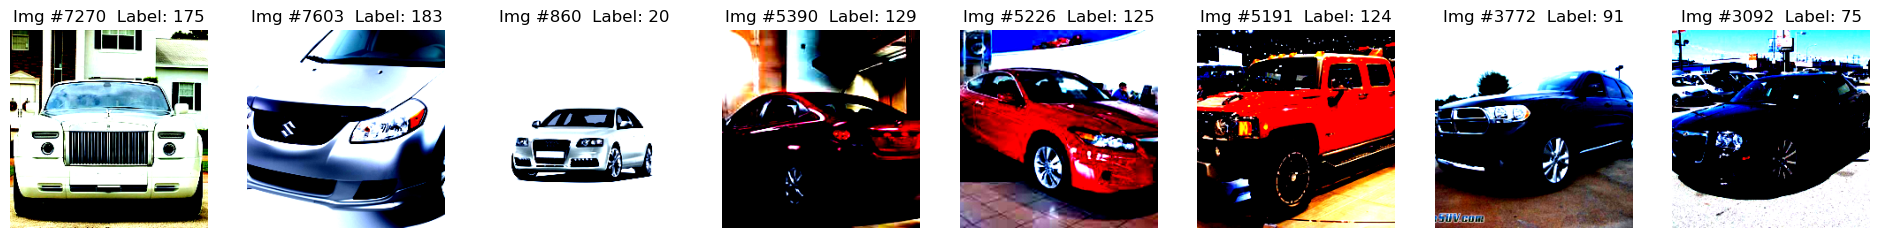

In [8]:
utils.display_images(val_dataset, NUM_images=8)

In [9]:
mixup = v2.MixUp(num_classes=196)

In [10]:
from tqdm import tqdm

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
def train_epoch(model, train_loader, optimizer, criterion, device, mixup = None):

    """ 
    Training a model for one epoch.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - epoch (int): Current epoch number.
    - device (torch.device): The device on which to perform training (e.g., 'cuda' or 'cpu').

    Returns:
    - float: Mean training loss for the epoch.
    - list: List of individual training losses for each batch.
    """
    
    loss_list = []
    acc_list = []
    #progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (images, labels) in enumerate(train_loader):
        if mixup is not None:
            images, labels = mixup(images, labels)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)

        # # calculate accuracy
        # with torch.no_grad():
        #     predicted = outputs.argmax(dim=-1)
        #     correct = (predicted == labels).sum().item()
        #     accuracy = correct/labels.shape[0] * 100

#         acc_list.append(accuracy)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    mean_acc = []
    return mean_loss, loss_list, mean_acc

In [14]:
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs, scheduler=None, start_epoch=0):
    """ 
    Training a model for a given number of epochs.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler (optional).
    - start_epoch (int): Starting epoch number.

    Returns:
    - list: List of mean training losses for each epoch.
    - list: List of mean validation losses for each epoch.
    - list: List of individual training losses for each batch.
    - list: List of validation accuracies for each epoch.
    """
    wandb.watch(model, criterion, log='gradients', log_freq=100)

    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    train_acc = []
    for epoch in tqdm(range(start_epoch, start_epoch+num_epochs)):
           
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, _, mean_acc = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, device=device, mixup = mixup
            )
        if scheduler is not None:
            scheduler.step()
        train_loss.append(mean_loss)
        train_acc.append(mean_acc)

        
        #loss_iters = loss_iters + cur_loss_iters
        
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = utils.eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
       
        wandb.log({'epoch': epoch, 'loss': loss, 'accuracy': accuracy}, step=epoch)
        
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, train_acc

Convnext - Combined approach

In [134]:
convnext = torchvision.models.convnext_tiny(weights='DEFAULT')

In [ ]:
# Freezing model parameters
for param in convnext.parameters():
    param.requires_grad = False

In [ ]:
# Parameters of newly constructed modules have requires_grad=True by default
convnext.classifier[2] = nn.Linear(convnext.classifier[2].in_features, 196)
# )
# convnext.fc = nn.Sequential(
#     nn.linear(num_logits, 784),
#     nn.Linear(796, 196))
convnext = convnext.to(device)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, convnext.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [ ]:
params

150724

In [ ]:
LR = float(config["LRConvNext"])

In [ ]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(convnext.parameters(), lr=LR)

In [ ]:
with wandb.init(project='finetuning_convnext_combined'):
    train_loss, val_loss, _ , valid_acc, train_acc = train_model(
            model=convnext, optimizer=optimizer, criterion=criterion,
            train_loader=trainloader, valid_loader=testloader, num_epochs=15, start_epoch=0
        )
    # Unfreezing model parameters
    for param in convnext.parameters():
        param.requires_grad = True
        
    # Lowering learning rate
    for g in optimizer.param_groups:
        g['lr'] *= 0.1
        
    next_train_loss, next_val_loss, _ , next_valid_acc, next_train_acc = train_model(
        model=convnext, optimizer=optimizer, criterion=criterion,
        train_loader=trainloader, valid_loader=testloader, num_epochs=15, start_epoch=15
    )
wandb.finish()

  7%|█████▌                                                                              | 1/15 [01:21<18:58, 81.30s/it]

Epoch 1/15
    Train loss: 5.01867
    Valid loss: 4.06855
    Accuracy: 14.329567779960708%




 40%|█████████████████████████████████▌                                                  | 6/15 [08:03<12:06, 80.69s/it]

Epoch 6/15
    Train loss: 3.89125
    Valid loss: 2.72249
    Accuracy: 39.29273084479371%




 73%|████████████████████████████████████████████████████████████▊                      | 11/15 [14:45<05:21, 80.47s/it]

Epoch 11/15
    Train loss: 3.57185
    Valid loss: 2.35501
    Accuracy: 46.57416502946955%




100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [20:08<00:00, 80.54s/it]


Epoch 15/15
    Train loss: 3.45916
    Valid loss: 2.2021
    Accuracy: 49.74214145383104%


Training completed


  7%|█████▌                                                                              | 1/15 [01:24<19:38, 84.16s/it]

Epoch 16/15
    Train loss: 3.22115
    Valid loss: 1.21334
    Accuracy: 68.23428290766208%




 40%|█████████████████████████████████▌                                                  | 6/15 [08:23<12:34, 83.80s/it]

Epoch 21/15
    Train loss: 2.36429
    Valid loss: 0.73728
    Accuracy: 82.18320235756386%




 73%|████████████████████████████████████████████████████████████▊                      | 11/15 [15:21<05:34, 83.54s/it]

Epoch 26/15
    Train loss: 2.16671
    Valid loss: 0.60654
    Accuracy: 85.80550098231828%




100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [20:52<00:00, 83.52s/it]

Training completed


accuracy,▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▆▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▆▆▅▅▅▅▅▅▅▄▄▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,87.5
epoch,29
loss,0.52429


In [ ]:
concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_train_acc = train_acc + next_train_acc
concat_valid_acc = valid_acc + next_valid_acc

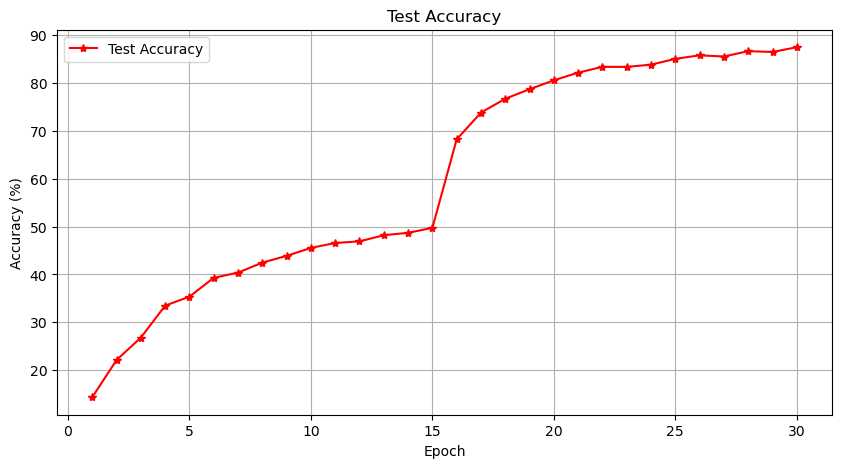

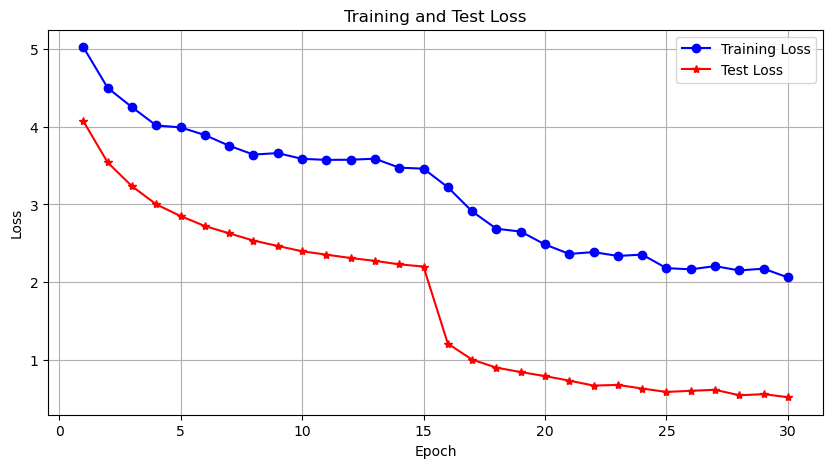

In [ ]:
utils.plot_accuracy_epoch(concat_valid_acc, concat_train_acc)
utils.plot_loss_epoch(concat_train_loss, concat_val_loss)

In [ ]:
swin_transformer = torchvision.models.swin_t(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /home/user/rogf1/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|█████████████████████████████████████████████████████████████████████████████████| 108M/108M [00:00<00:00, 115MB/s]


In [ ]:
swin_transformer.head = nn.Linear(swin_transformer.head.in_features, 196)

swin_transformer = swin_transformer.to(device)

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, convnext.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Trainable parameters in Swin-Transformer model: {params}")

Trainable parameters in Swin-Transformer model: 27970852


In [ ]:
LR = float(config["LRSwin"])

In [ ]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(swin_transformer.parameters(), lr=LR)

In [ ]:
with wandb.init(project='finetuning_swin_endtoend'):
    train_loss, val_loss, _ , valid_acc, train_acc = train_model(
            model=swin_transformer, optimizer=optimizer, criterion=criterion,
            train_loader=trainloader, valid_loader=testloader, num_epochs=30, start_epoch=0
        )

  3%|██▊                                                                                 | 1/30 [01:21<39:22, 81.46s/it]

Epoch 1/30
    Train loss: 5.22275
    Valid loss: 4.6121
    Accuracy: 6.139489194499018%




 20%|████████████████▊                                                                   | 6/30 [08:11<32:51, 82.15s/it]

Epoch 6/30
    Train loss: 3.0466
    Valid loss: 1.10149
    Accuracy: 73.1213163064833%




 37%|██████████████████████████████▍                                                    | 11/30 [14:58<25:47, 81.45s/it]

Epoch 11/30
    Train loss: 2.69498
    Valid loss: 0.70848
    Accuracy: 82.07269155206288%




 53%|████████████████████████████████████████████▎                                      | 16/30 [21:46<19:03, 81.64s/it]

Epoch 16/30
    Train loss: 2.49171
    Valid loss: 0.5804
    Accuracy: 84.86001964636543%




 70%|██████████████████████████████████████████████████████████                         | 21/30 [28:36<12:19, 82.16s/it]

Epoch 21/30
    Train loss: 2.1671
    Valid loss: 0.50754
    Accuracy: 86.41944990176817%




 87%|███████████████████████████████████████████████████████████████████████▉           | 26/30 [35:26<05:28, 82.17s/it]

Epoch 26/30
    Train loss: 2.10027
    Valid loss: 0.48452
    Accuracy: 86.81237721021611%




100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [40:52<00:00, 81.76s/it]

Epoch 30/30
    Train loss: 2.05143
    Valid loss: 0.46646
    Accuracy: 87.78241650294696%


Training completed


accuracy,▁▃▅▆▆▇▇▇▇▇▇███████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,87.78242
epoch,29
loss,0.46646


In [ ]:
concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_train_acc = train_acc + next_train_acc
concat_valid_acc = valid_acc + next_valid_acc

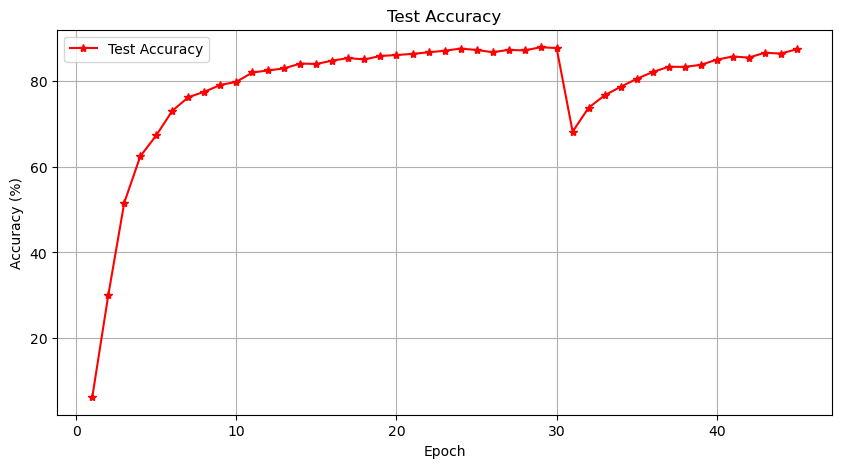

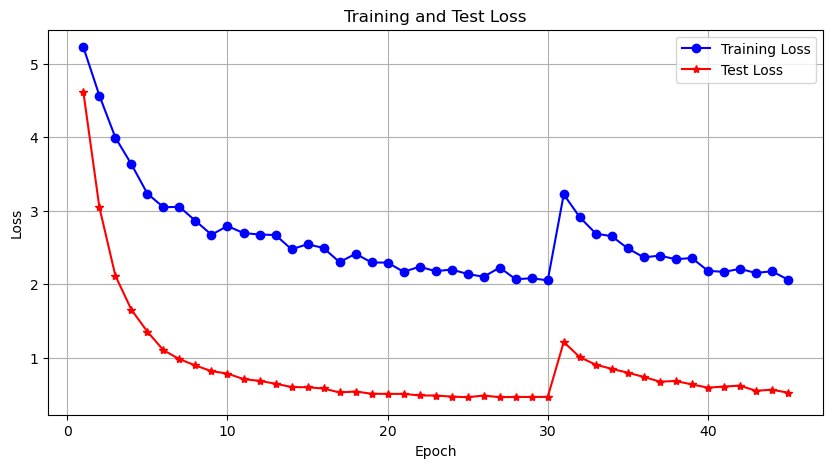

In [ ]:
utils.plot_accuracy_epoch(concat_valid_acc, concat_train_acc)
utils.plot_loss_epoch(concat_train_loss, concat_val_loss)

# Resnet18

In [17]:
from tqdm import tqdm
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
model = models.resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Finetuning: ResNet

In [20]:
# Adapt feedforward connection to our model
num_in_neurons = model.fc.in_features
model.fc = nn.Linear(num_in_neurons, 196)
model = model.to(device)

In [21]:
with wandb.init(project='finetune_resnet', config = config): 
    train_loss, val_loss, _ , valid_acc, _ = train_model(model=model, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=30, start_epoch=0)
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: skywalkerlke (luke_team). Use `wandb login --relogin` to force relogin


  3%|▎         | 1/30 [01:20<39:03, 80.81s/it]

Epoch 1/30
    Train loss: 5.13667
    Valid loss: 4.38768
    Accuracy: 11.861493123772101%




 20%|██        | 6/30 [08:04<32:20, 80.87s/it]

Epoch 6/30
    Train loss: 3.63415
    Valid loss: 2.25608
    Accuracy: 52.455795677799614%




 37%|███▋      | 11/30 [14:48<25:35, 80.81s/it]

Epoch 11/30
    Train loss: 2.94567
    Valid loss: 1.554
    Accuracy: 69.48673870333988%




 53%|█████▎    | 16/30 [21:30<18:45, 80.41s/it]

Epoch 16/30
    Train loss: 2.76817
    Valid loss: 1.29286
    Accuracy: 77.13654223968565%




 70%|███████   | 21/30 [28:13<12:04, 80.54s/it]

Epoch 21/30
    Train loss: 2.59184
    Valid loss: 1.30341
    Accuracy: 78.04518664047151%




 87%|████████▋ | 26/30 [34:55<05:21, 80.36s/it]

Epoch 26/30
    Train loss: 2.50526
    Valid loss: 1.20327
    Accuracy: 79.75196463654224%




100%|██████████| 30/30 [40:14<00:00, 80.50s/it]

Epoch 30/30
    Train loss: 2.55796
    Valid loss: 1.1595
    Accuracy: 81.33595284872298%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█▇█████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▂▁
accuracy,81.33595
epoch,29
loss,1.1595


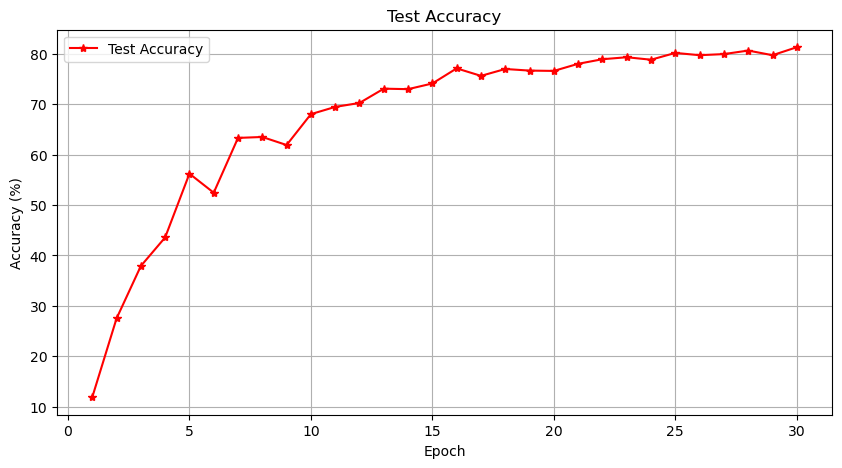

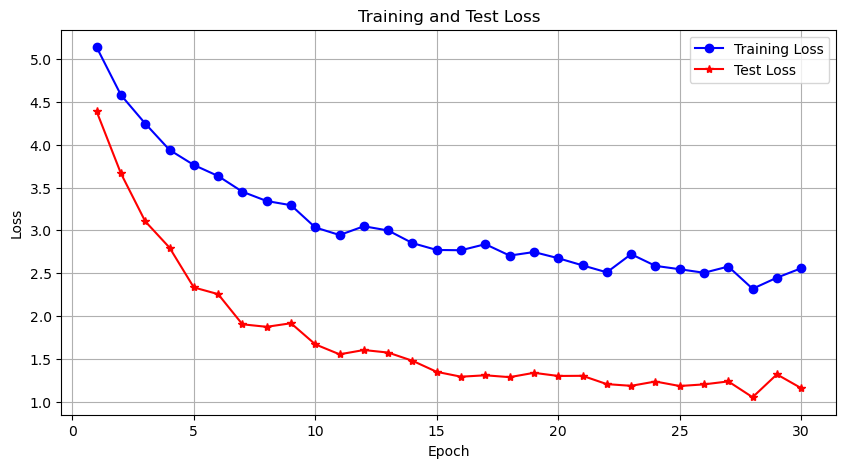

In [22]:
utils.plot_accuracy_epoch(valid_acc)
utils.plot_loss_epoch(train_loss, val_loss)


ResNet (almost) converged to an accuracy of around 81%, which is very good given the difficulty of the dataset.
Somewthing we observe throughout our evaluation with ResNet (and other models) is a training loss being above our test loss. 
We believe that the reason for this is that many of our augmentations are very hard to train on.
A visual interpretation for this could be to imagine our dataset as a distribution where we sample our data from. The augmentations are always deviations from the distribution, which go in different directions, but stay centered around the core distribution.  Thus we mostly train/work with our original distribution, but our of distribution samples become hearder to evaluate. This however is just a theoretical intuition, which needs more research. Nevertheless, we note that further training with less augmentations decreased our training loss significantly and led to more normal looking loss curves. 

## ConvNet as a Feature Extractor: ResNet

In [21]:
fixedModel = torchvision.models.resnet18(pretrained=True)

# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Adapt feedforward connection to our model
num_in_neurons = fixedModel.fc.in_features
fixedModel.fc = nn.Linear(num_in_neurons, 196)

# Reinitialize the criterion and optimizer, in order to avoid optimizing the wrong parameters
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=LR)

fixedModel = fixedModel.to(device)

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
with wandb.init(project='feature_resnet', config = config): 
    train_loss, val_loss, _ , valid_acc, _ = train_model(model=fixedModel, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=30, start_epoch=0)
wandb.finish()

  3%|▎         | 1/30 [01:20<38:54, 80.49s/it]

Epoch 1/30
    Train loss: 5.36726
    Valid loss: 5.19658
    Accuracy: 1.3015717092337917%




 20%|██        | 6/30 [08:00<31:59, 79.99s/it]

Epoch 6/30
    Train loss: 4.86818
    Valid loss: 4.53884
    Accuracy: 10.609037328094303%




 37%|███▋      | 11/30 [14:43<25:26, 80.37s/it]

Epoch 11/30
    Train loss: 4.62779
    Valid loss: 4.16937
    Accuracy: 17.043222003929273%




 53%|█████▎    | 16/30 [21:23<18:41, 80.13s/it]

Epoch 16/30
    Train loss: 4.44697
    Valid loss: 3.88623
    Accuracy: 21.660117878192533%




 70%|███████   | 21/30 [28:06<12:04, 80.55s/it]

Epoch 21/30
    Train loss: 4.30236
    Valid loss: 3.7068
    Accuracy: 23.784381139489195%




 87%|████████▋ | 26/30 [34:51<05:23, 80.99s/it]

Epoch 26/30
    Train loss: 4.18902
    Valid loss: 3.56323
    Accuracy: 25.159626719056977%




100%|██████████| 30/30 [40:15<00:00, 80.50s/it]

Epoch 30/30
    Train loss: 4.12841
    Valid loss: 3.48458
    Accuracy: 27.480353634577604%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▂▂▃▃▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁
accuracy,27.48035
epoch,29
loss,3.48458


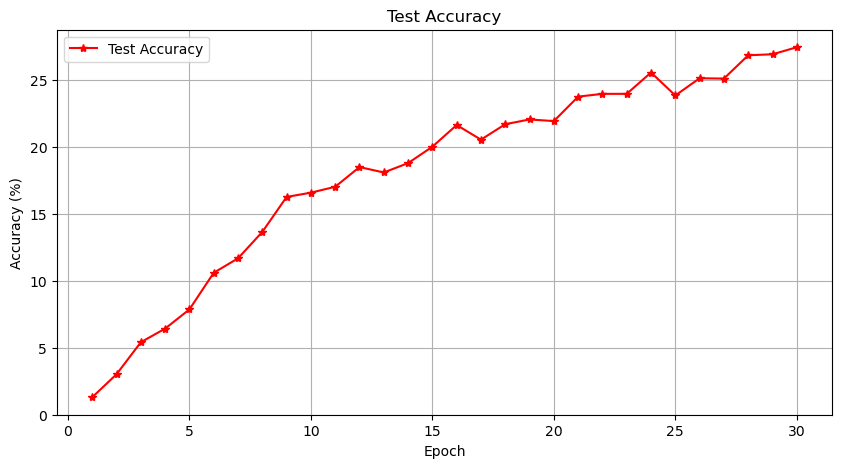

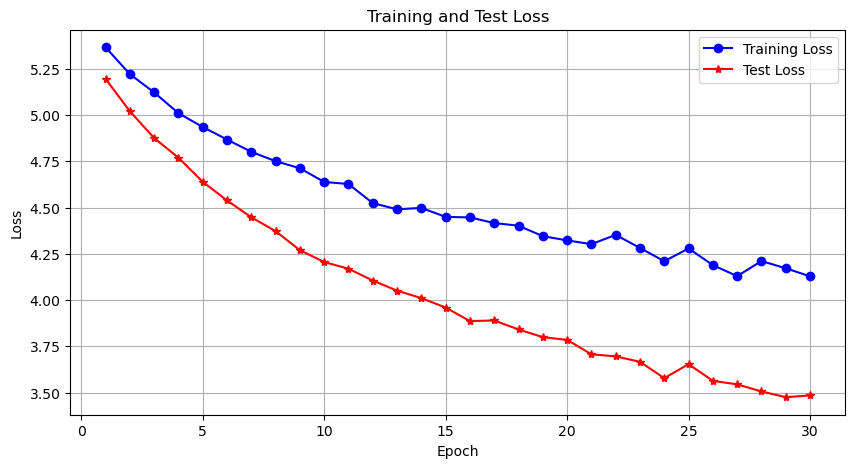

In [ ]:
utils.plot_accuracy_epoch(valid_acc)
utils.plot_loss_epoch(train_loss, val_loss)

Using ResNet as a feature extractor did not achieve very good results. With an accuracy of around 27% our model would not be close to be used in any application. While we do believe that more training epochs could have improved our results even further, the feature extractor methods appears to be the weakest method of finetuning in our analysis.

## Combined Approach: ResNet

First we train only the classifier for 10 epochs, then we fine tune the entire network

In [34]:
fixedModel = torchvision.models.resnet18(pretrained=True)

# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Adapt feedforward connection to our model
num_in_neurons = fixedModel.fc.in_features
fixedModel.fc = nn.Linear(num_in_neurons, 196)

# Reinitialize the criterion and optimizer, in order to avoid optimizing the wrong parameters
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=LR)

fixedModel = fixedModel.to(device)

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
with wandb.init(): 
    train_loss, val_loss, _ , valid_acc, _ = train_model(model=fixedModel, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=15, start_epoch=0)

  7%|▋         | 1/15 [01:21<19:06, 81.88s/it]

Epoch 1/15
    Train loss: 5.36941
    Valid loss: 5.18916
    Accuracy: 1.424361493123772%




 40%|████      | 6/15 [08:04<12:05, 80.57s/it]

Epoch 6/15
    Train loss: 4.86247
    Valid loss: 4.52432
    Accuracy: 10.891453831041257%




 73%|███████▎  | 11/15 [14:51<05:24, 81.24s/it]

Epoch 11/15
    Train loss: 4.58208
    Valid loss: 4.14968
    Accuracy: 16.674852652259332%




100%|██████████| 15/15 [20:12<00:00, 80.83s/it]

Epoch 15/15
    Train loss: 4.51785
    Valid loss: 3.97748
    Accuracy: 18.737721021611%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▄▄▅▅▆▆▇▇████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▅▄▄▃▃▂▂▂▁▁▁
accuracy,18.73772
epoch,14
loss,3.97748


In [36]:
# Unfreezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = True

In [37]:
# Lowering learning rate
for g in optimizer.param_groups:
    g['lr'] *= 0.1

In [38]:
with wandb.init(project='combined_approach_resnet', config= config): 
    new_train_loss, new_val_loss, _ , new_valid_acc, _ = train_model(model=fixedModel, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=15, start_epoch=15)
wandb.finish()

  7%|▋         | 1/15 [01:21<18:54, 81.06s/it]

Epoch 16/15
    Train loss: 4.23545
    Valid loss: 3.2736
    Accuracy: 31.18860510805501%




 40%|████      | 6/15 [08:07<12:18, 82.10s/it]

Epoch 21/15
    Train loss: 3.6993
    Valid loss: 2.39651
    Accuracy: 51.3015717092338%




 73%|███████▎  | 11/15 [14:55<05:24, 81.15s/it]

Epoch 26/15
    Train loss: 3.39375
    Valid loss: 1.99618
    Accuracy: 61.21070726915521%




100%|██████████| 15/15 [20:19<00:00, 81.28s/it]

Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▄▅▅▅▆▆▆▇▇█▇█
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▄▄▄▃▃▃▂▂▂▂▁
accuracy,66.68713
epoch,29
loss,1.75359


In [39]:
cat_train_loss = train_loss + new_train_loss
cat_val_loss = val_loss + new_val_loss
cat_valid_acc = valid_acc + new_valid_acc

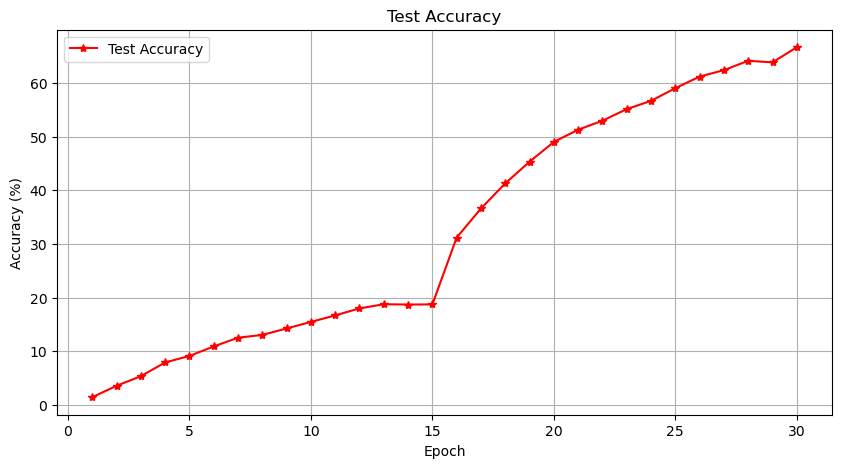

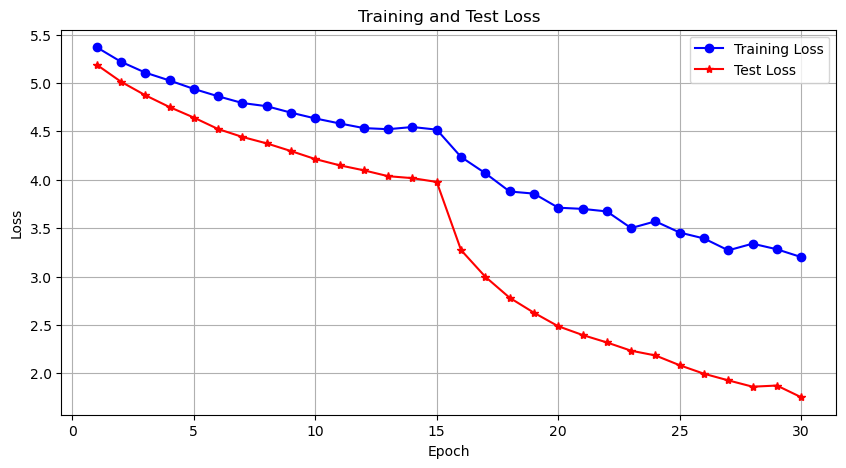

In [40]:
utils.plot_accuracy_epoch(cat_valid_acc)
utils.plot_loss_epoch(cat_train_loss, cat_val_loss)

In the combined approach we detect a steep decrease in test loss/ increase in accuracy after our switch to end to end finetuning. 

This is expected, due to the tremendous increase of optimizable parameters.
The final accuracy was however lower than when using end to end finetuning. 
Considering the shape of the loss curves, we believe that the test loss would decrease even further with more epochs, thus further improving our results.

# EfficientNet

Next we finetune the EfficientNet model. We note, that we chose to optimize the baseline model. This way we did not 'optimize' the models parameters to our specific classification problem. According to the paper, this could have made our model more efficient and more powerful.

In [44]:
# Current bug, when loading EfficientNet weights, the code below solves this until the fix comes out
# Source: https://github.com/pytorch/vision/issues/7744

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url


def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

model = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True)



In [48]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=196, bias=True)
)

# Reinitialize the criterion and optimizer, in order to avoid optimizing the wrong parameters
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model = model.to(device)

In [49]:
with wandb.init(project='efficient_net_finetuning', config = config): 
    train_loss, val_loss, _ , valid_acc, _ = train_model(model=model, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=30, start_epoch=0)
wandb.finish()

  3%|▎         | 1/30 [01:21<39:22, 81.46s/it]

Epoch 1/30
    Train loss: 5.16647
    Valid loss: 4.42074
    Accuracy: 12.610510805500983%




 20%|██        | 6/30 [08:06<32:22, 80.95s/it]

Epoch 6/30
    Train loss: 3.13797
    Valid loss: 1.35972
    Accuracy: 69.80599214145383%




 37%|███▋      | 11/30 [14:55<25:47, 81.44s/it]

Epoch 11/30
    Train loss: 2.70734
    Valid loss: 0.97598
    Accuracy: 79.58005893909626%




 53%|█████▎    | 16/30 [21:40<18:54, 81.00s/it]

Epoch 16/30
    Train loss: 2.68907
    Valid loss: 0.93992
    Accuracy: 83.44793713163064%




 70%|███████   | 21/30 [28:27<12:10, 81.14s/it]

Epoch 21/30
    Train loss: 2.4954
    Valid loss: 0.83905
    Accuracy: 84.55304518664047%




 87%|████████▋ | 26/30 [35:12<05:24, 81.06s/it]

Epoch 26/30
    Train loss: 2.39309
    Valid loss: 0.80085
    Accuracy: 85.97740667976424%




100%|██████████| 30/30 [40:39<00:00, 81.32s/it]

Epoch 30/30
    Train loss: 2.32989
    Valid loss: 0.76374
    Accuracy: 86.61591355599214%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▃▄▅▆▆▇▇▇▇▇▇██████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,86.61591
epoch,29
loss,0.76374


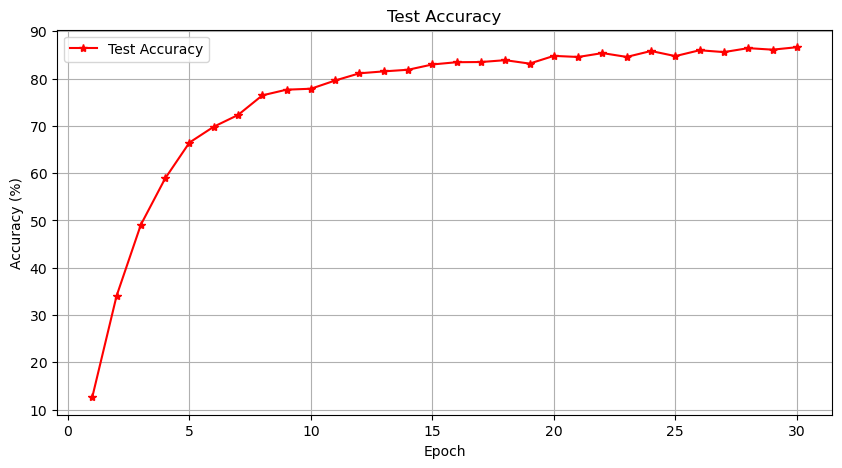

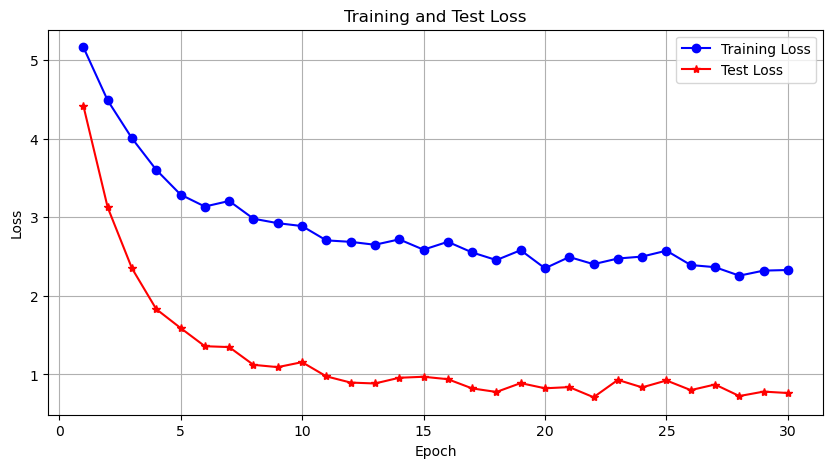

In [50]:
utils.plot_accuracy_epoch(valid_acc)
utils.plot_loss_epoch(train_loss, val_loss)

While also showing unusual loss curves, EfficientNet performed very well, achieving an accuracy almost comparable to the swin transformer or ConvNext. 

As with our models above we believe that tuning our hyperparameters and transforms we can improve the results even further. 

# Experiment 2: 

First of all we want to note, that the dataset was already defined to be in a 50/50 train test split. This is far from optimal. Nevertheless, we were curious how far we could take our results without changing the train/test split (i.e. using more train data). We would also like to comment, that we achieved more sucess with end to end finetuning than with the combined finetuning approach. This differs from the information taught in class, which might give indication that further hyperparametertuning with the combined approach might give even more promosing solutions.


In [118]:
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])

LR = float(config['LR'])

config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4', 'LRConvNext': '1e-3'}


In [119]:
from tqdm import tqdm


In [120]:
class LearningRateSchedulerWithWarmup():
    '''
    Parameters: 
    optimizer: pytorch optimizer used during training
    lr: learning rate
    warmup_epochs: number of epochs we warm up our learning rate

    milestones: List of epochs when the learning rate will be reduced by a factor
    gamma: Factor by which the learning rate will be reduced
    '''
    def __init__(self, optimizer, lr, milestones, gamma = 0.5, warmup_epochs = 5):
        self.optimizer = optimizer
        self.lr = lr
        self.warmup_epochs = warmup_epochs
        self.milestones = milestones
        self.gamma = gamma
        self.current_lr = 0

    def step(self, epoch):
        if epoch <= self.warmup_epochs:
            # Warm-up phase: Linearly increase learning rate
            self.current_lr = (epoch / self.warmup_epochs) * self.lr
        else:
            if epoch in self.milestones:
                self.current_lr *= self.gamma

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_lr

# Process of choosing our training setup: Swinnet

We first tried to make the model overfit more, due to our highly unusual loss curves. Our idea was, that sampling from a distribution closer to our dataset would help our goal, which is why we opted to reduce the number of data augmentations. We observed that especially RandomResizedCrop was heavily responsible for our loss curves.

Removing the augmentation/ some of our augmentations made our problem initially much easier to learn, resulting in high accuracies at early epochs. However, the algorithm also seemed to converge quite quickly. In contrast, when we opted to use Cropping and our other augmentations the algorithm started to learn very slowly but did not seem to converge at all. Even at higher epochs (20+) we were able to observe accuracy gains.

Additionally, we decided to not use the CenterCrop transform on our evaluation set. While this is usually helpful and leads to increases of 1 or 2 points in accuracy, the unorthodox dataset choice does not make this optimal anymore. In the dataset we found many car pictures, which were heavily zoomed in. A center cropping would not have been beneficial here.

After our observations we did not achieve siginificant accuracy gains however leading to us scrapping the Swinnet model and continuing with ConvNext.


# Process of choosing our training setup: ConvNext

Regarding transforms we made similar observations. In order to avoid overfitting and improving our validation loss we needed one RandomHorizontalFlip and RandomCropping. This is on difference to Swinnet, where RandomHorizontalFlip was not enough. Accuracies which rise quickly but also plateau and decrease quickly are mostly part of us not using enough augmentations. We found out that contrary to Swinnet Mixup was especially helpful in deviating from our distribution. In addition it also benefitted our accuracy. This makes sense intuitively. Some cars look extremely similar. Keeping in mind that the final probabilities should give a measure of uncertainty, soft probabilites on similar images reinforce that idea (given that two similar images are merged).

Using all transforms however did not increase our accuracy. It stayed the same when using end to end finetuning. Thus we decided for an intermediate option. We included Random ResizedCropping, but made sure that the minimum scale was set to 0.5. This ensured that we do not stray too far from our original distribution. This resulted in our best results so far: 91/92% with weakened randomresizedcropping. Note that completely removing it makes us lose 2%. Therefore we opted against it. 

Center cropping in the validation set also did not seem too important, due to similar argumentation as above.

Adding additional transforms helped our performance as well. We argue that other augmentations are helping our performance, due to us augmenting our dataset with more similar examples. This is why perhaps randomsized cropping with smaller scales did not work too well. More out of distribition sampling was not necessary, more data however is always beneficial in some way.

Looking at schedulers we chose to reduce on plateau, which seemed to be an obvious choice to take while optimizing other hyperparameters. We finally opted with our self-implemented scheduler with warmup, which achieved similar results.

For the optimizer we chose AdamW a slightly optimized version of Adam published by Hütter's Lab, choosing cross entropy loss was our choice of loss function. Both choices are very popular in the literature and obvious choices.

In [121]:
# Looking at the data some pictures are strongly zoomed in, further center cropping is thus not really beneficial
data_transforms = {
    'train': transforms.Compose([
        v2.RandomResizedCrop(224, scale = (0.5,1.0)),
        v2.Resize((224, 224)),
        v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.Resize((224, 224)),
        # v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = datasets.ImageFolder(
root='data/car_data/car_data/test',
transform=data_transforms['train']
)
val_dataset = datasets.ImageFolder(
root='data/car_data/car_data/train',
transform=data_transforms['val'])

mixup = v2.MixUp(num_classes=196)
# mixup = None


/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [122]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Create separate trainloader for the mixup training
trainloader_mixup = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [123]:
def train_epoch(model, train_loader, optimizer, criterion, device, mixup = None):

    """ 
    Training a model for one epoch.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - epoch (int): Current epoch number.
    - device (torch.device): The device on which to perform training (e.g., 'cuda' or 'cpu').

    Returns:
    - float: Mean training loss for the epoch.
    - list: List of individual training losses for each batch.
    """
    
    loss_list = []
    acc_list = []
    #progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (images, labels) in enumerate(train_loader):
        if mixup is not None:
            images, labels = mixup(images, labels)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        
        #calculate accuracy
        # with torch.no_grad():
        #     predicted = outputs.argmax(dim=-1)
        #     correct = (predicted == labels).sum().item()
        #     accuracy = correct/labels.shape[0] * 100

#         acc_list.append(accuracy)

        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    mean_acc = []
    return mean_loss, loss_list, mean_acc

In [124]:
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs, scheduler=None, start_epoch=0):
    """ 
    Training a model for a given number of epochs.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler (optional).
    - start_epoch (int): Starting epoch number.

    Returns:
    - list: List of mean training losses for each epoch.
    - list: List of mean validation losses for each epoch.
    - list: List of individual training losses for each batch.
    - list: List of validation accuracies for each epoch.
    """
    wandb.watch(model, criterion, log='gradients', log_freq=100)

    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    train_acc = []
    for epoch in tqdm(range(start_epoch, start_epoch+num_epochs)):
           
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, _, mean_acc = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, device=device, mixup = mixup
            )
        train_loss.append(mean_loss)
        train_acc.append(mean_acc)

        
        #loss_iters = loss_iters + cur_loss_iters
        
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = utils.eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
       
        if scheduler is not None:
            # scheduler.step(loss)
            scheduler.step(epoch = epoch)
        wandb.log({'epoch': epoch, 'loss': loss, 'accuracy': accuracy}, step=epoch)
        
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        if(epoch % 1 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, train_acc

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [126]:
'''
swin_transformer = torchvision.models.swin_t(weights='DEFAULT')
# Freezing model parameters
for param in swin_transformer.parameters():
    param.requires_grad = False

swin_transformer.head = nn.Linear(swin_transformer.head.in_features, 196)

swin_transformer = swin_transformer.to(device)
'''

convnext = torchvision.models.convnext_tiny(weights='DEFAULT')
convnext.classifier[2] = nn.Linear(convnext.classifier[2].in_features, 196)
# )
# convnext.fc = nn.Sequential(
#     nn.linear(num_logits, 784),
#     nn.Linear(796, 196))
convnext = convnext.to(device)

In [127]:
# classification loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
# optimizer = torch.optim.AdamW(swin_transformer.parameters(), lr=3e-4)
optimizer = torch.optim.AdamW(convnext.parameters(), lr=3e-4)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)
scheduler = LearningRateSchedulerWithWarmup(optimizer, 3e-4, milestones=[10, 15, 20, 25], gamma = 0.5, warmup_epochs=5)

In [128]:
# acc, loss = utils.eval_model(model = swin_transformer, criterion=criterion, eval_loader=testloader, device = device)

In [129]:
with wandb.init(project='convnext_endtoend_final'):
    train_loss, val_loss, _ , valid_acc, train_acc = train_model(
            model=convnext, optimizer=optimizer, criterion=criterion,
            train_loader=trainloader, scheduler=scheduler, valid_loader=testloader, num_epochs=30, start_epoch=0
        )

  3%|▎         | 1/30 [01:33<45:01, 93.17s/it]

Epoch 1/30
    Train loss: 5.25833
    Valid loss: 4.76074
    Accuracy: 3.818762278978389%




  7%|▋         | 2/30 [02:57<41:06, 88.11s/it]

Epoch 2/30
    Train loss: 4.92501
    Valid loss: 4.75901
    Accuracy: 3.818762278978389%




 10%|█         | 3/30 [04:21<38:44, 86.11s/it]

Epoch 3/30
    Train loss: 4.39166
    Valid loss: 3.48304
    Accuracy: 33.7794695481336%




 13%|█▎        | 4/30 [05:46<37:05, 85.61s/it]

Epoch 4/30
    Train loss: 3.59683
    Valid loss: 2.14538
    Accuracy: 61.640471512770134%




 17%|█▋        | 5/30 [07:09<35:22, 84.91s/it]

Epoch 5/30
    Train loss: 2.88701
    Valid loss: 1.30385
    Accuracy: 75.55255402750491%




 20%|██        | 6/30 [08:34<33:52, 84.67s/it]

Epoch 6/30
    Train loss: 2.4382
    Valid loss: 0.91194
    Accuracy: 81.39734774066798%




 23%|██▎       | 7/30 [09:58<32:25, 84.58s/it]

Epoch 7/30
    Train loss: 2.28567
    Valid loss: 0.826
    Accuracy: 81.47102161100196%




 27%|██▋       | 8/30 [11:22<30:58, 84.46s/it]

Epoch 8/30
    Train loss: 2.09286
    Valid loss: 0.70187
    Accuracy: 84.24607072691552%




 30%|███       | 9/30 [12:47<29:35, 84.55s/it]

Epoch 9/30
    Train loss: 1.9704
    Valid loss: 0.65186
    Accuracy: 85.37573673870334%




 33%|███▎      | 10/30 [14:12<28:14, 84.70s/it]

Epoch 10/30
    Train loss: 1.91835
    Valid loss: 0.58802
    Accuracy: 86.76326129666012%




 37%|███▋      | 11/30 [15:37<26:52, 84.87s/it]

Epoch 11/30
    Train loss: 1.89399
    Valid loss: 0.59979
    Accuracy: 86.75098231827111%




 40%|████      | 12/30 [17:03<25:29, 84.99s/it]

Epoch 12/30
    Train loss: 1.61906
    Valid loss: 0.49394
    Accuracy: 89.08398821218074%




 43%|████▎     | 13/30 [18:26<23:55, 84.44s/it]

Epoch 13/30
    Train loss: 1.61185
    Valid loss: 0.47592
    Accuracy: 89.64882121807466%




 47%|████▋     | 14/30 [19:50<22:32, 84.52s/it]

Epoch 14/30
    Train loss: 1.69346
    Valid loss: 0.46472
    Accuracy: 89.64882121807466%




 50%|█████     | 15/30 [21:15<21:09, 84.61s/it]

Epoch 15/30
    Train loss: 1.50137
    Valid loss: 0.43531
    Accuracy: 90.50834970530451%




 53%|█████▎    | 16/30 [22:38<19:37, 84.11s/it]

Epoch 16/30
    Train loss: 1.61739
    Valid loss: 0.47049
    Accuracy: 89.83300589390963%




 57%|█████▋    | 17/30 [24:03<18:15, 84.26s/it]

Epoch 17/30
    Train loss: 1.42314
    Valid loss: 0.41032
    Accuracy: 91.35559921414537%




 60%|██████    | 18/30 [25:28<16:52, 84.39s/it]

Epoch 18/30
    Train loss: 1.45841
    Valid loss: 0.40136
    Accuracy: 91.19597249508841%




 63%|██████▎   | 19/30 [26:52<15:28, 84.43s/it]

Epoch 19/30
    Train loss: 1.50447
    Valid loss: 0.40529
    Accuracy: 91.03634577603144%




 67%|██████▋   | 20/30 [28:18<14:08, 84.85s/it]

Epoch 20/30
    Train loss: 1.38651
    Valid loss: 0.4146
    Accuracy: 91.2696463654224%




 70%|███████   | 21/30 [29:44<12:46, 85.18s/it]

Epoch 21/30
    Train loss: 1.37641
    Valid loss: 0.39277
    Accuracy: 91.35559921414537%




 73%|███████▎  | 22/30 [31:09<11:21, 85.24s/it]

Epoch 22/30
    Train loss: 1.44982
    Valid loss: 0.401
    Accuracy: 91.38015717092338%




 77%|███████▋  | 23/30 [32:33<09:54, 84.94s/it]

Epoch 23/30
    Train loss: 1.37392
    Valid loss: 0.39604
    Accuracy: 91.62573673870334%




 80%|████████  | 24/30 [34:02<08:35, 85.97s/it]

Epoch 24/30
    Train loss: 1.35306
    Valid loss: 0.38753
    Accuracy: 91.74852652259332%




 83%|████████▎ | 25/30 [35:30<07:13, 86.71s/it]

Epoch 25/30
    Train loss: 1.26681
    Valid loss: 0.39171
    Accuracy: 91.60117878192534%




 87%|████████▋ | 26/30 [36:59<05:48, 87.18s/it]

Epoch 26/30
    Train loss: 1.31982
    Valid loss: 0.39593
    Accuracy: 91.2328094302554%




 90%|█████████ | 27/30 [38:27<04:22, 87.55s/it]

Epoch 27/30
    Train loss: 1.23856
    Valid loss: 0.37973
    Accuracy: 91.52750491159135%




 93%|█████████▎| 28/30 [39:55<02:55, 87.66s/it]

Epoch 28/30
    Train loss: 1.26581
    Valid loss: 0.37974
    Accuracy: 91.73624754420432%




 97%|█████████▋| 29/30 [41:24<01:28, 88.00s/it]

Epoch 29/30
    Train loss: 1.29681
    Valid loss: 0.39446
    Accuracy: 91.72396856581533%




100%|██████████| 30/30 [42:51<00:00, 85.72s/it]

Epoch 30/30
    Train loss: 1.24844
    Valid loss: 0.37753
    Accuracy: 91.78536345776031%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▃▆▇▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,██▆▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,91.78536
epoch,29
loss,0.37753


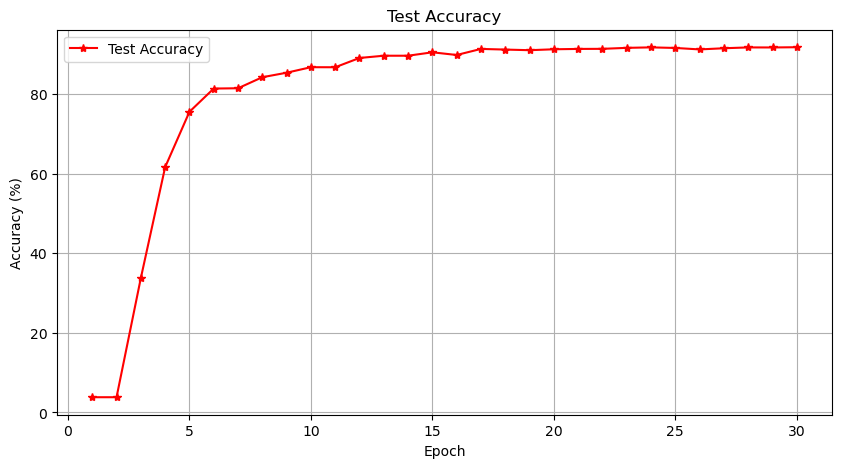

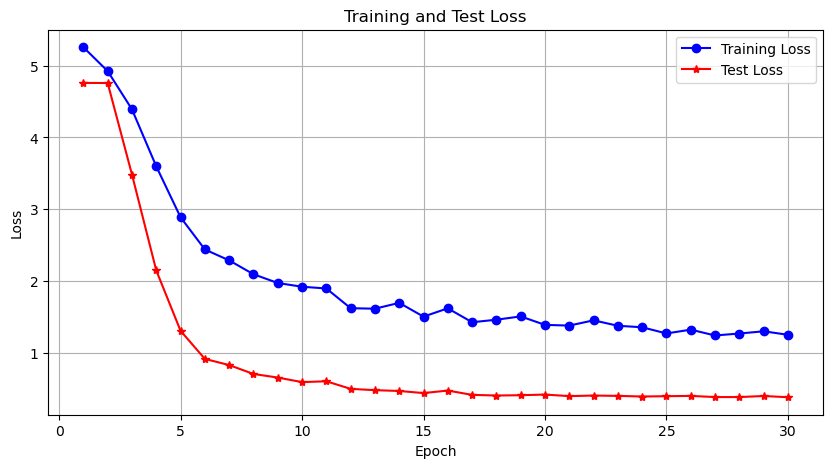

In [130]:
utils.plot_accuracy_epoch(valid_acc)
utils.plot_loss_epoch(train_loss, val_loss)

The training and test loss look as expected given our earlier observations. A more detailed discussion of our choices of hyperparameters and results can be found above.